In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np

import psycopg2

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'bdeops',
    'password': 'BD30ps99!',
    'options': f'-c search_path=bde',
}

In [14]:
# with psycopg2.connect(**dbparams) as conn:
#     with conn.cursor() as cur:
#         cur.execute("""
#         CREATE VIEW unique_compound AS
#         SELECT DISTINCT ON (smiles) *
#         FROM compound 
#         ORDER BY smiles, run DESC;""")
        
# with psycopg2.connect(**dbparams) as conn:
#     with conn.cursor() as cur:
#         cur.execute("""
#         CREATE VIEW reaction_bde AS
#         SELECT rid, molecule, bond_index, fragment1, fragment2,
#         (cpd1.enthalpy + cpd2.enthalpy - cpd_mol.enthalpy) * 627.509 AS BDE,
#         (cpd1.freeenergy + cpd2.freeenergy - cpd_mol.freeenergy) * 627.509 AS BDFE,
#         (cpd1.scfenergy + cpd2.scfenergy - cpd_mol.scfenergy) * 627.509 AS BDSCFE        
#         FROM reaction
#         LEFT JOIN unique_compound AS cpd_mol ON reaction.molecule = cpd_mol.smiles
#         LEFT JOIN unique_compound AS cpd1 ON reaction.fragment1 = cpd1.smiles
#         LEFT JOIN unique_compound AS cpd2 ON reaction.fragment2 = cpd2.smiles 
#         WHERE cpd1.enthalpy IS NOT NULL
#         AND cpd2.enthalpy IS NOT NULL
#         AND cpd_mol.enthalpy IS NOT NULL AND
#         cpd1.freeenergy IS NOT NULL AND
#         cpd2.freeenergy IS NOT NULL AND
#         cpd_mol.freeenergy IS NOT NULL AND
#         cpd1.scfenergy IS NOT NULL AND
#         cpd2.scfenergy IS NOT NULL AND
#         cpd_mol.scfenergy IS NOT NULL;""")

In [15]:
with psycopg2.connect(**dbparams) as conn:
    cdf = pd.read_sql_query("""
    SELECT * from unique_compound where status='finished';
    """, conn)
    
    rdf = pd.read_sql_query("""
    SELECT * from reaction_bde;
    """, conn)    

In [16]:
from tqdm import tqdm
tqdm.pandas()

from rdkit import Chem
from collections import Counter
def get_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    elems = Counter((atom.GetSymbol() for atom in Chem.AddHs(mol).GetAtoms()))
    return pd.Series(elems)
    

elems = cdf.smiles.progress_apply(get_elements)

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  3%|▎         | 15577/501544 [00:13<03:14, 2501.77it/s]RDKit WARNING: [12:17:42] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [12:17:42]   BondStereo set to STEREONONE and single bond directions set to NONE.
  3%|▎         | 15840/501544 [00:13<03:11, 2537.83it/s]RDKit WARNING: [12:17:42] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [12:17:42]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [12:17:42] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [12:17:42]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [12:17:42] Conflicting single bond directions around d

In [17]:
le_10 = elems.drop('H', 1).sum(1) <= 10

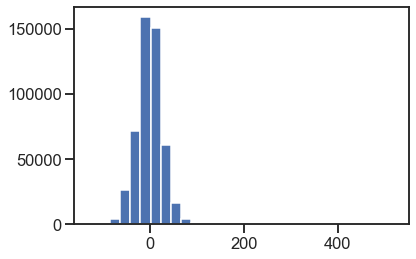

In [18]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=False)
reg.fit(elems[le_10].fillna(0), cdf[le_10].enthalpy)
enthalpy_pred = reg.predict(elems[le_10].fillna(0))

ethalpy_err = (cdf[le_10].enthalpy - enthalpy_pred) * 627.509
plt.hist(ethalpy_err, bins=30)

q1 = ethalpy_err.quantile(.25)
q3 = ethalpy_err.quantile(.75)
iqr = q3 - q1

enthalpy_max = q3 + 3 * iqr
enthalpy_min = q1 - 3 * iqr

cdf_small = cdf[le_10][ethalpy_err < enthalpy_max]

In [19]:
cdf_small.shape

(494775, 16)

In [20]:
is_valid = rdf[['molecule', 'fragment1', 'fragment2']].apply(lambda x: x.isin(cdf_small.smiles), 0).all(1)
rdfv = rdf[is_valid]

In [21]:
len(rdf)

1181126

In [22]:
len(rdfv)

1170615

Text(0.5, 0, 'BDE')

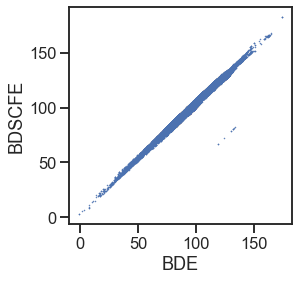

In [46]:
plt.figure(figsize=(4,4))
plt.plot(rdfv.bde, rdfv.bdscfe, '.', ms=1)
plt.ylabel('BDSCFE')
plt.xlabel('BDE')

<AxesSubplot:ylabel='Frequency'>

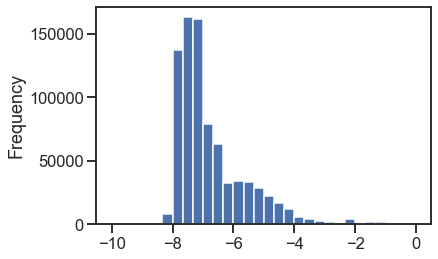

In [47]:
(rdfv.bde - rdfv.bdscfe).plot.hist(bins=30, range=(-10, 0))

In [48]:
scf_invalid = (((rdfv.bde - rdfv.bdscfe) < -9) | ((rdfv.bde - rdfv.bdscfe) > -1.9))
rdfv = rdfv[~scf_invalid]

In [52]:
rdfv = rdfv.drop_duplicates(subset=['molecule', 'bond_index'])

In [53]:
rdfv.shape

(810706, 8)

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
train, test = train_test_split(rdfv.molecule.unique(), test_size=1000, random_state=1)
train, valid = train_test_split(train, test_size=1000, random_state=1)

In [56]:
rdfv['set'] = 'train'
rdfv.loc[rdfv.molecule.isin(valid), 'set'] = 'valid'
rdfv.loc[rdfv.molecule.isin(test), 'set'] = 'test'

In [57]:
rdfv.to_csv('2021015_rdf_new_elements.csv.gz', compression='gzip', index=False)